# Курсовая работа

In [1]:
import time
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA, TruncatedSVD
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RFC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

C:\Users\GruXsqK\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\GruXsqK\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
start_notebook = time.time()

## Обзор сырых данных

In [3]:
# Статические сведения
profiles = pd.read_csv('train/profiles.zip', sep=';', nrows=5, encoding='utf-8')
profiles

,user_id,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
0,e54f91bf5895d0c433fd1cd3092ab4ad94ea953845f4a8...,None,None,0,30,1,1
1,f1ab2f683a3b37c9f9f6cb107629178cdcc34eaf684b67...,22,M,0,34,1,0
2,0dc419c3401bb042fea254ae11c4bfc5e1418f2ab63c8b...,22,M,0,13,1,1
3,bd32ea1b0f4d9289e4a551e84c6858338d352c5ac85b14...,25,F,0,2,1,1
4,357dc65b7ee8b90d268c9020bc31aef91bd59dc6b27398...,20,M,0,382,1,1


In [4]:
# Донат и статус игроков
sample = pd.read_csv('train/sample.zip', sep=';', nrows=5, encoding='utf-8')
sample

,user_id,is_churned,login_last_dt,level,donate_total
0,1e7edd8347e3aaeedf8c494b11240851e3fa0ad231b8f8...,0,2019-09-03,43,88730.00000
1,f43cac5f14e06ca039b173e14c323ac0c1fd8492f0cf08...,0,2019-09-18,50,44149.00000
2,cc7450e0b182947998534ef137b05e07109c100aced0b6...,0,2019-09-22,37,44931.00000
3,5c583d57a1e9e53341fc239d41fb6983e667a04b1b4d94...,0,2019-09-06,20,37538.00000
4,9bbaa1a2501e8dc83cf6c0c54ef139c75c99de09dcf4dc...,0,2019-09-01,10,4100.97998


In [5]:
# Платежи
payments = pd.read_csv('train/payments.zip', sep=';', nrows=5, encoding='utf-8')
payments

,log_dt,user_id,pay_amt,trans_amt
0,2019-08-06,dfbca74f54a4c8cb5ee7e1e3281e8a40bd8b439b3de52f...,488.0,2
1,2019-09-28,9c302c0a540df3f3ca48642b6c09cca4dc479eb5f23835...,300.0,1
2,2019-08-22,d6b1d64a61ed83ab5672c990bac8d71fda5011b74269df...,4500.0,1
3,2019-09-01,f17aa62688b3aac5538c23f2b538b9a89797bc3b40d6d5...,1000.0,1
4,2019-08-14,cab7c3810da2c1618acde4601fec0feb003f109dfd6883...,18.0,1


In [6]:
# Жалобы на игроков
reports = pd.read_csv('train/reports.zip', sep=';', nrows=5, encoding='utf-8')
reports

,log_dt,user_id,reports_amt
0,2019-08-14,9395f1b1764c58e82e18a67af55ba01dad809ac022761f...,1
1,2019-08-19,2036664f62b3ca2a52d9bd2c4c34f2a803c8004d9ee5af...,1
2,2019-08-15,37c63021a603fc1b2ccb3adfe9346046c6ab78da153491...,2
3,2019-09-02,904018e3cf927eb936c431cf228abc8417e206dd9553f6...,2
4,2019-08-25,a089378a18313807f2eeabbfeee7cf4a5a68c3d7c9fe0f...,2


In [7]:
# Участие в сессиях с нарушителями
abusers = pd.read_csv('train/abusers.zip', sep=';', nrows=5, encoding='utf-8')
abusers

,log_dt,user_id,sess_with_abusers_amt
0,2019-09-20,f8f2caba0902acc4b891f23602b5409282a1c619453cc7...,5
1,2019-09-21,ee602b935ebb19a33f8b955975d9a8a2e568d95ed62270...,3
2,2019-08-28,50db13c3dc694949fc24c5f8253c8dac6946e16fc2f2e3...,14
3,2019-08-23,ec5090799e94795b6d85d9f8f36cfa539f21d9c7ab2bc2...,2
4,2019-08-22,e1dcb04b42380fa9d886ed4aa3b3fc8bd249d34253c8b9...,3


In [8]:
# Входы в игру
logins = pd.read_csv('train/logins.zip', sep=';', nrows=5, encoding='utf-8')
logins

,log_dt,user_id,disconnect_amt,session_amt
0,2019-08-10,deb67d0e87069771d646670f6b00bff99d1b03420891c2...,0,1
1,2019-09-09,3e32fbd5f4e337a512dd1b897cf091e572b795ab277812...,0,3
2,2019-09-12,73b282dd676e9b05116e64a8101c77293294a0179e0fba...,0,2
3,2019-08-13,9e97e0838ed2d5ff6bd69bf5740abba9188efa3555353c...,1,2
4,2019-08-19,30189c2273cde414ab4b6ad2f3654e6fc704d8497388db...,1,2


In [9]:
# Качество связи с игровыми серверами (пинг)
pings = pd.read_csv('train/pings.zip', sep=';', nrows=5, encoding='utf-8')
pings

,log_dt,user_id,avg_min_ping
0,2019-09-21,d146c346f1adb74686ff5ad24cec0962c0c0be7f1adcc5...,4.000000
1,2019-09-16,d64abfcfb5c0af725fb83d2d5115d828c1074a69747ffc...,61.000000
2,2019-09-29,955f77e93ea5d654a595bdfdd4ba72dffe1cda66ae1c67...,23.000000
3,2019-09-18,cc7a5e519c78a292b4375ff16c986b071c8a02f7dae2a1...,30.000000
4,2019-09-29,9df615f28505af55c08673b4211bafedbbe8b7cda41cd5...,44.666668


In [10]:
# Игровые сессии
sessions = pd.read_csv('train/sessions.zip', sep=';', nrows=5, encoding='utf-8')
sessions

,log_dt,user_id,kd,win_rate,leavings_rate,session_player
0,2019-09-29,3ea931e4262fd0b02b806af34aca37a9e1c0bc3d46b39c...,1.140845,1.333333,0.000000,4103.0
1,2019-09-07,91f7f580798df049e7fbd82f9c8978dc8526a6d3820d3e...,1.017544,0.000000,0.000000,2502.0
2,2019-08-07,9f197d8152463a06e8a9108c442c238cdd7e4d4e2fdda9...,1.230179,0.576923,0.073171,24222.0
3,2019-09-20,5e4713eea35cb8fc8e2faa7d5b82e409ee089aec9ceb8b...,1.036364,1.000000,0.000000,4158.0
4,2019-09-21,0555ca8f0b13c290378939b512533f8037e41795a9dab1...,1.369318,0.142857,0.000000,3735.0


### Описание полей сырых данных

__profiles__ - профили

* user_id - идентификатор игрока (во всех остальных файлах имеет тот же смысл)
* age - возраст (получен из даты рождения, что указана в БД)
* gender - пол (M - Male, F - Female)
* days_between_reg_fl - дней между регистрацией и первым входом
* days_between_fl_df - дней между первым входом и первым платежом
* has_return_date - есть дата возврата (игрок когда-то уходил и возвращался)
* has_phone_number - есть привязка номера телефона к аккаунту

__payments__ - платежи

* log_dt - дата события (во всех остальных файлах имеет тот же смысл)
* pay_amt - размер внесенных средств (сумма платежей за данную дату)
* trans_amt - кол-во транзакций за данную даты

__reports__ - жалобы игрока на других пользователей

* reports_amt - кол-во жалоб (на читы/оскорбления)

__abusers__ - сессии с нарушителями

* sess_with_abusers_amt - кол-во сессий с теми, на кого жаловались другие игроки

__logins__ - входы

* disconnect_amt - кол-во завершений игры из-за технической проблемы
* session_amt - кол-во сессий (от входа в клиент игры до выхода)

__pings__ - пинг до серверов (чем меньше, тем лучше интернет соединение и игра меньше "глючит")

* avg_min_ping - средний за данную дату пинг до ближайшего сервера

__sessions__ - информация о сессиях (матчах)

* kd - Kills/Deaths - отношение убийств к смертям, то есть насколько успешно играл пользователь
* win_rate - Wins/Matches - отношение кол-во матчей, закончившихся победой, к общему числу матчей, тоже мера успешности
* leavings_rate - Leavings/Matches - отношение кол-во матчей, покинутых игроком, к общему числу матчей
* session_player - суммарное время в матчах за данную дату (в секундах)

__shop__ - активность в магазине

* silver_spent - траты серебра
* gold_spent - траты золота

## Создание датасета

In [11]:
def time_format(sec):
    return str(timedelta(seconds=sec))


def build_dataset_raw(churned_start_date='2019-01-01', 
                      churned_end_date='2019-02-01', 
                      inter_list=[(1,7),(8,14)],
                      raw_data_path='train/',
                      dataset_path='dataset/', 
                      mode='train'):
    
    start_t = time.time()
 
    sample = pd.read_csv('{}sample.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    profiles = pd.read_csv('{}profiles.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    payments = pd.read_csv('{}payments.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    reports = pd.read_csv('{}reports.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    abusers = pd.read_csv('{}abusers.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    logins = pd.read_csv('{}logins.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    pings = pd.read_csv('{}pings.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    sessions = pd.read_csv('{}sessions.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    shop = pd.read_csv('{}shop.zip'.format(raw_data_path), sep=';', na_values=['\\N', 'None'], encoding='utf-8')
    
    print('Run time (reading csv files): {}'.format(time_format(time.time()-start_t)))    
#-----------------------------------------------------------------------------------------------------    
    print('NO dealing with outliers, missing values and categorical features...')
#-----------------------------------------------------------------------------------------------------        
    # На основании дня отвала (last_login_dt) строим признаки, которые описывают активность игрока перед уходом
    
    print('Creating dataset...')
    # Создадим пустой датасет - в зависимости от режима построения датасета - train или test
    if mode == 'train':
        dataset = sample.copy()[['user_id', 'is_churned', 'level', 'donate_total']]
    elif mode == 'test':
        dataset = sample.copy()[['user_id', 'level', 'donate_total']]

    # Пройдемся по всем источникам, содержащим "динамичекие" данные
    for df in [payments, reports, abusers, logins, pings, sessions, shop]:

        # Получим 'day_num_before_churn' для каждого из значений в источнике для определения недели
        data = pd.merge(sample[['user_id', 'login_last_dt']], df, on='user_id')
        data['day_num_before_churn'] = 1 + (data['login_last_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - 
                                data['log_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))).apply(lambda x: x.days)
        df_features = data[['user_id']].drop_duplicates().reset_index(drop=True)

        # Для каждого признака создадим признаки для каждого из времененно интервала (в нашем примере 4 интервала по 7 дней)
        features = list(set(data.columns) - set(['user_id', 'login_last_dt', 'log_dt', 'day_num_before_churn']))
        print('Processing with features:', features)
        for feature in features:
            for i, inter in enumerate(inter_list):
                inter_df = data.loc[data['day_num_before_churn'].between(inter[0], inter[1], inclusive=True)].\
                                groupby('user_id')[feature].mean().reset_index().\
                                rename(index=str, columns={feature: feature+'_{}'.format(i+1)})
                df_features = pd.merge(df_features, inter_df, how='left', on='user_id')

        # Добавляем построенные признаки в датасет
        dataset = pd.merge(dataset, df_features, how='left', on='user_id')
        
        print('Run time (calculating features): {}'.format(time_format(time.time()-start_t)))

    # Добавляем "статические" признаки
    dataset = pd.merge(dataset, profiles, on='user_id')
#---------------------------------------------------------------------------------------------------------------------------
    dataset.to_csv('{}dataset_raw_{}.csv'.format(dataset_path, mode), sep=';', index=False)
    print('Dataset is successfully built and saved to {}, run time "build_dataset_raw": {}'.\
          format(dataset_path, time_format(time.time()-start_t)))

In [12]:
# Следует из исходных данных
CHURNED_START_DATE = '2019-09-01' 
CHURNED_END_DATE = '2019-10-01'

INTER_1 = (1,7)
INTER_2 = (8,14)
INTER_3 = (15,21)
INTER_4 = (22,28)
INTER_LIST = [INTER_1, INTER_2, INTER_3, INTER_4]

In [13]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='train/',
                  dataset_path='dataset/', 
                  mode='train')

Run time (reading csv files): 0:02:04.645988
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 0:02:32.730848
Processing with features: ['reports_amt']
Run time (calculating features): 0:04:16.044541
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:09:19.347308
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 0:15:21.284447
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:21:09.377718
Processing with features: ['kd', 'leavings_rate', 'session_player', 'win_rate']
Run time (calculating features): 0:27:12.761622
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 0:33:39.531911
Dataset is successfully built and saved to dataset/, run time "build_dataset_raw": 0:34:11.479177


In [14]:
build_dataset_raw(churned_start_date=CHURNED_START_DATE,
                  churned_end_date=CHURNED_END_DATE,
                  inter_list=INTER_LIST,
                  raw_data_path='test/',
                  dataset_path='dataset/', 
                  mode='test')

Run time (reading csv files): 0:00:11.796456
NO dealing with outliers, missing values and categorical features...
Creating dataset...
Processing with features: ['trans_amt', 'pay_amt']
Run time (calculating features): 0:00:14.611339
Processing with features: ['reports_amt']
Run time (calculating features): 0:00:24.356214
Processing with features: ['sess_with_abusers_amt']
Run time (calculating features): 0:00:53.319224
Processing with features: ['session_amt', 'disconnect_amt']
Run time (calculating features): 0:01:28.185086
Processing with features: ['avg_min_ping']
Run time (calculating features): 0:02:01.995546
Processing with features: ['kd', 'leavings_rate', 'session_player', 'win_rate']
Run time (calculating features): 0:02:36.483073
Processing with features: ['gold_spent', 'silver_spent']
Run time (calculating features): 0:03:12.404756
Dataset is successfully built and saved to dataset/, run time "build_dataset_raw": 0:03:15.363071


In [15]:
train = pd.read_csv('dataset/dataset_raw_train.csv', sep=';')
test = pd.read_csv('dataset/dataset_raw_test.csv', sep=';')
print(train.shape, test.shape)

(469475, 62) (44764, 61)


In [16]:
train.head()

,user_id,is_churned,level,donate_total,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,...,silver_spent_1,silver_spent_2,silver_spent_3,silver_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
0,1e7edd8347e3aaeedf8c494b11240851e3fa0ad231b8f8...,0,43,88730.00000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,40900.0,300.000000,25000.000000,26.0,M,0,7,1,1
1,f43cac5f14e06ca039b173e14c323ac0c1fd8492f0cf08...,0,50,44149.00000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,41480.0,6266.666667,1400.000000,27.0,M,0,37,1,1
2,cc7450e0b182947998534ef137b05e07109c100aced0b6...,0,37,44931.00000,1.0,1.0,NaN,2.0,63.000000,350.0,...,14471.428571,31400.0,5714.285714,414.285714,21.0,M,0,153,1,1
3,5c583d57a1e9e53341fc239d41fb6983e667a04b1b4d94...,0,20,37538.00000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22.0,M,0,156,1,1
4,9bbaa1a2501e8dc83cf6c0c54ef139c75c99de09dcf4dc...,0,10,4100.97998,1.0,NaN,NaN,NaN,66.580002,NaN,...,0.000000,0.0,1666.666667,9838.000000,2.0,M,0,21,1,1


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469475 entries, 0 to 469474
Data columns (total 62 columns):
user_id                    469475 non-null object
is_churned                 469475 non-null int64
level                      469475 non-null int64
donate_total               469475 non-null float64
trans_amt_1                67485 non-null float64
trans_amt_2                60928 non-null float64
trans_amt_3                56720 non-null float64
trans_amt_4                57896 non-null float64
pay_amt_1                  67485 non-null float64
pay_amt_2                  60928 non-null float64
pay_amt_3                  56720 non-null float64
pay_amt_4                  57896 non-null float64
reports_amt_1              144916 non-null float64
reports_amt_2              145909 non-null float64
reports_amt_3              147492 non-null float64
reports_amt_4              147503 non-null float64
sess_with_abusers_amt_1    261313 non-null float64
sess_with_abusers_amt_2    259432 n

## Обработка датасета

In [18]:
def prepare_dataset(dataset, 
                    dataset_type='train',
                    dataset_path='dataset/'):
    print(dataset_type)
    start_t = time.time()
    print('Dealing with missing values, outliers, categorical features...')
    
    # Профили
    dataset['age'] = dataset['age'].fillna(dataset['age'].median())
    dataset['gender'] = dataset['gender'].fillna(dataset['gender'].mode()[0])
    dataset.loc[~dataset['gender'].isin(['M', 'F']), 'gender'] = dataset['gender'].mode()[0]
    dataset['gender'] = dataset['gender'].map({'M': 1., 'F':0.})
    dataset.loc[(dataset['age'] > 80) | (dataset['age'] < 7), 'age'] = round(dataset['age'].median())
    dataset.loc[dataset['days_between_fl_df'] < -1, 'days_between_fl_df'] = -1
    # Пинги
    for period in range(1,len(INTER_LIST)+1):
        col = 'avg_min_ping_{}'.format(period)
        dataset.loc[(dataset[col] < 0) | 
                    (dataset[col].isnull()), col] = dataset.loc[dataset[col] >= 0][col].median()
    # Сессии и прочее
    dataset.fillna(0, inplace=True)
    dataset.to_csv('{}dataset_{}.csv'.format(dataset_path, dataset_type), sep=';', index=False)
         
    print('Dataset is successfully prepared and saved to {}, run time (dealing with bad values): {}'.\
          format(dataset_path, time_format(time.time()-start_t)))

In [19]:
prepare_dataset(dataset=train, dataset_type='train')
prepare_dataset(dataset=test, dataset_type='test')

train
Dealing with missing values, outliers, categorical features...
Dataset is successfully prepared and saved to dataset/, run time (dealing with bad values): 0:00:36.707378
test
Dealing with missing values, outliers, categorical features...
Dataset is successfully prepared and saved to dataset/, run time (dealing with bad values): 0:00:03.450440


In [20]:
train_new = pd.read_csv('dataset/dataset_train.csv', sep=';')
test_new = pd.read_csv('dataset/dataset_test.csv', sep=';')

In [21]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469475 entries, 0 to 469474
Data columns (total 62 columns):
user_id                    469475 non-null object
is_churned                 469475 non-null int64
level                      469475 non-null int64
donate_total               469475 non-null float64
trans_amt_1                469475 non-null float64
trans_amt_2                469475 non-null float64
trans_amt_3                469475 non-null float64
trans_amt_4                469475 non-null float64
pay_amt_1                  469475 non-null float64
pay_amt_2                  469475 non-null float64
pay_amt_3                  469475 non-null float64
pay_amt_4                  469475 non-null float64
reports_amt_1              469475 non-null float64
reports_amt_2              469475 non-null float64
reports_amt_3              469475 non-null float64
reports_amt_4              469475 non-null float64
sess_with_abusers_amt_1    469475 non-null float64
sess_with_abusers_amt_2    

In [22]:
train_new.describe()

,is_churned,level,donate_total,trans_amt_1,trans_amt_2,trans_amt_3,trans_amt_4,pay_amt_1,pay_amt_2,pay_amt_3,...,silver_spent_1,silver_spent_2,silver_spent_3,silver_spent_4,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
count,469475.000000,469475.000000,4.694750e+05,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,...,4.694750e+05,4.694750e+05,4.694750e+05,4.694750e+05,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000,469475.000000
mean,0.029448,26.792698,4.800206e+04,0.198513,0.182546,0.173069,0.173995,140.415895,134.262708,129.077459,...,6.444131e+03,5.700765e+03,4.550476e+03,4.724096e+03,26.002226,0.933899,14.340597,218.709164,0.882946,0.830589
std,0.169058,12.680296,8.576742e+04,0.573882,0.567848,0.562879,0.553329,597.573949,603.785240,613.631584,...,2.559970e+04,1.978590e+04,1.452183e+04,1.475799e+04,8.341266,0.248460,114.818230,363.410345,0.321485,0.375115
min,0.000000,10.000000,6.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,17.000000,6.312000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.000000,1.000000,0.000000,8.000000,1.000000,1.000000
50%,0.000000,23.000000,2.019600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,24.000000,1.000000,0.000000,56.000000,1.000000,1.000000
75%,0.000000,36.000000,5.543250e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.500000e+03,4.000000e+03,3.542857e+03,3.800000e+03,31.000000,1.000000,0.000000,266.000000,1.000000,1.000000
max,1.000000,50.000000,4.356043e+06,18.000000,44.285714,26.857143,18.000000,56700.000000,56598.857143,46400.000000,...,8.060050e+06,1.618050e+06,2.244387e+06,1.514500e+06,80.000000,1.000000,2534.000000,2683.000000,1.000000,1.000000


In [23]:
train_new['is_churned'].value_counts()

0    455650
1     13825
Name: is_churned, dtype: int64

## Балансировка классов

In [24]:
X = train_new.drop(['user_id', 'is_churned'], axis=1)
y = train_new['is_churned']

X_mm = StandardScaler().fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = ADASYN(random_state=21, sampling_strategy=0.4).fit_sample(X_train, y_train)

In [26]:
from collections import Counter

print('До:', Counter(y_train.values))
print('После:', Counter(y_train_balanced))

До: Counter({0: 318955, 1: 9677})
После: Counter({0: 318955, 1: 126695})


## Выбор модели

In [27]:
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def model_fit_predict(clf, X_train, y_train, X_test, y_test):
    start_t = time.time()
    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    print(f'\n{clf.__class__} fit and predict is successfully\nrun time: {time_format(time.time()-start_t)}')
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

### Logistic Regression

In [28]:
clf_lr = LR(n_jobs=-1, random_state=21, solver='saga', penalty='elasticnet', l1_ratio=0.01)
model_fit_predict(clf_lr, X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.188451390298356
Recall: 0.44768563162970104
F1: 0.2652478217397514
Log Loss: 0.3080261049505507
ROC AUC: 0.8081784147838015

<class 'sklearn.linear_model._logistic.LogisticRegression'> fit and predict is successfully
run time: 0:01:15.434872


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.01, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=21, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### Random Forest Classifier

In [29]:
clf_rfc = RFC(n_estimators=500, min_samples_leaf=3, n_jobs=-1, random_state=21)
model_fit_predict(clf_rfc, X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.34706016929764355
Recall: 0.36571841851494696
F1: 0.35614508745157886
Log Loss: 0.12004784417010665
ROC AUC: 0.9102903055507614

<class 'sklearn.ensemble._forest.RandomForestClassifier'> fit and predict is successfully
run time: 0:04:12.023797


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

### XGBoost

In [30]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=21, n_jobs=-1)
model_fit_predict(clf_xgb, X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.3351278600269179
Recall: 0.3601735776277724
F1: 0.34719962816639555
Log Loss: 0.11308792205636713
ROC AUC: 0.9053838219253862

<class 'xgboost.sklearn.XGBClassifier'> fit and predict is successfully
run time: 0:01:16.744884


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

### CatBoost

In [31]:
clf_ctb = CatBoostClassifier(n_estimators=100, learning_rate=0.1,
                             random_state=21, langevin=True,
                             thread_count=-1, logging_level='Silent')

model_fit_predict(clf_ctb, X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.35532493204843096
Recall: 0.34667309546769526
F1: 0.3509456985967053
Log Loss: 0.10947544512118236
ROC AUC: 0.903898862713141

<class 'catboost.core.CatBoostClassifier'> fit and predict is successfully
run time: 0:00:22.583423


## Отбор признаков

#### RFE (Recursive Feature Elimination)

In [32]:
STEP = 5

selector = RFECV(estimator=clf_lr, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 15


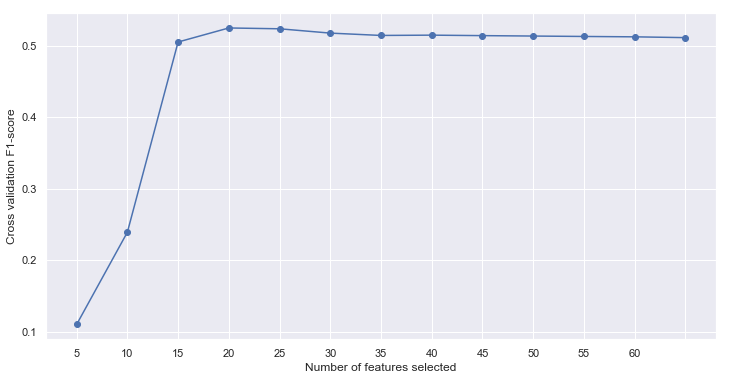

In [33]:
plt.figure(figsize=(12,6))
sns.set(font_scale=1)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

#### Feature Importance

Precision: 0.3351278600269179
Recall: 0.3601735776277724
F1: 0.34719962816639555
Log Loss: 0.11308792205636713
ROC AUC: 0.9053838219253862

<class 'xgboost.sklearn.XGBClassifier'> fit and predict is successfully
run time: 0:01:16.161548


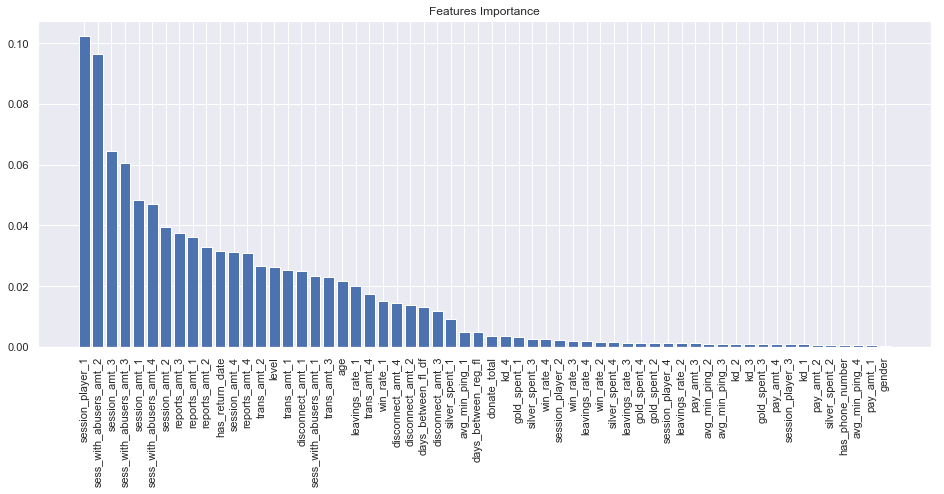

In [34]:
fitted_clf = model_fit_predict(clf_xgb, X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance_XGB = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

In [35]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance_XGB[0][:20]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance_XGB[0][:20]]

fitted_clf = model_fit_predict(clf_xgb, X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.3334697217675941
Recall: 0.39296046287367403
F1: 0.36077910579902606
Log Loss: 0.11459908175279239
ROC AUC: 0.9005224503107401

<class 'xgboost.sklearn.XGBClassifier'> fit and predict is successfully
run time: 0:00:31.783214
Признаков было: 60
Признаков стало: 20


#### Взаимная информация

In [36]:
mic = mutual_info_classif(X_train_balanced, y_train_balanced)

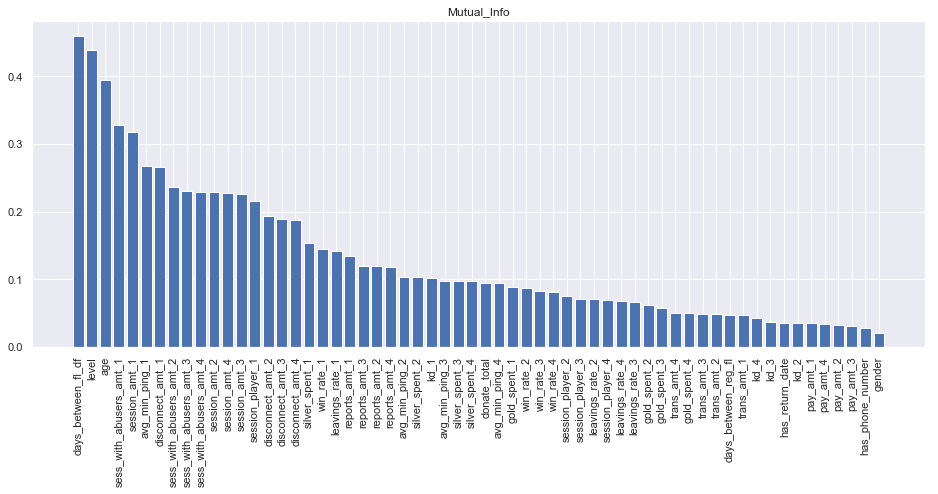

In [37]:
feature_importance_MIC = plot_importance(mic, X.columns, 'Mutual_Info')

In [38]:
X_train_MIC = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance_MIC[0][:20]]
X_test_MIC = pd.DataFrame(X_test, columns=X.columns)[feature_importance_MIC[0][:20]]

fitted_clf = model_fit_predict(clf_xgb, X_train_MIC, y_train_balanced, X_test_MIC, y_test)

Precision: 0.3302393746946751
Recall: 0.32594021215043395
F1: 0.3280757097791798
Log Loss: 0.11797106794614101
ROC AUC: 0.8957481202388257

<class 'xgboost.sklearn.XGBClassifier'> fit and predict is successfully
run time: 0:00:33.308712


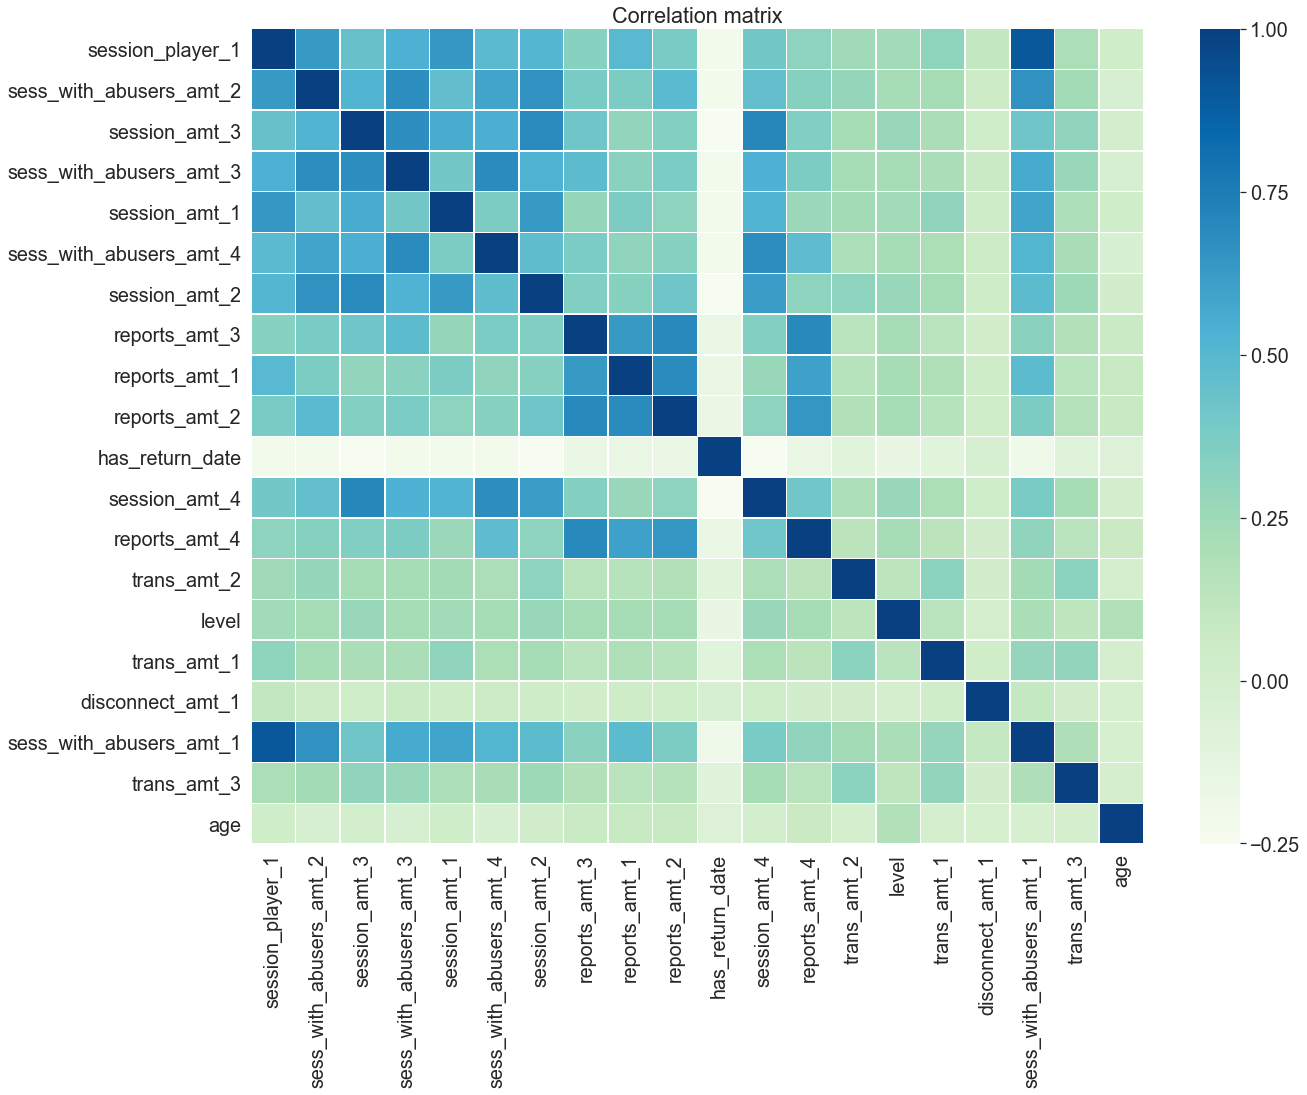

In [39]:
def get_corr_matrix_plot(data):
    plt.figure(figsize = (20,15))

    sns.set(font_scale=1.8)
    sns.heatmap(data.corr(), annot=False, linewidths=0.5, cmap='GnBu')

    plt.title('Correlation matrix')
    plt.show()
    
get_corr_matrix_plot(X_train_FI)

In [40]:
# финальный класификатор
clf_final = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, random_state=21, n_jobs=-1, max_depth=5)

best_feature = feature_importance_XGB[0][:20]

### Оценка качества модели

In [41]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

<Figure size 864x432 with 0 Axes>

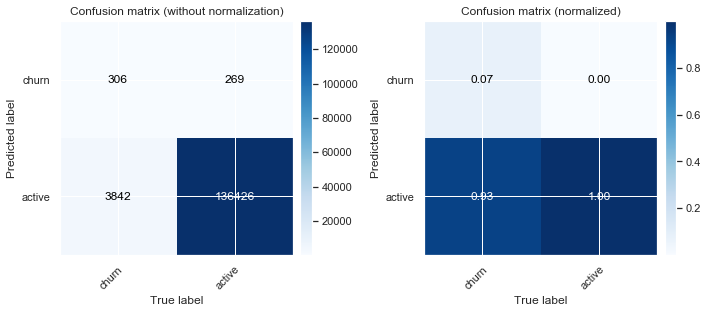

In [42]:
plt.figure(figsize = (12,6))
sns.set(font_scale=1)

model = clf_final.fit(X_train, y_train)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

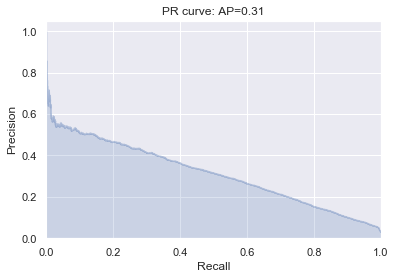

In [43]:
plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()

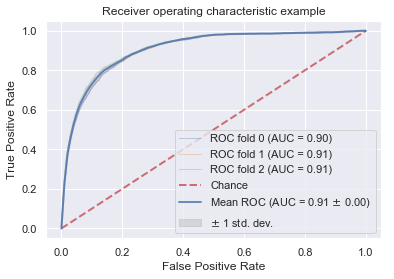

In [44]:
plot_ROC_curve(classifier=model, 
               X=X_test, 
               y=y_test.values, 
               n_folds=3)

In [45]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

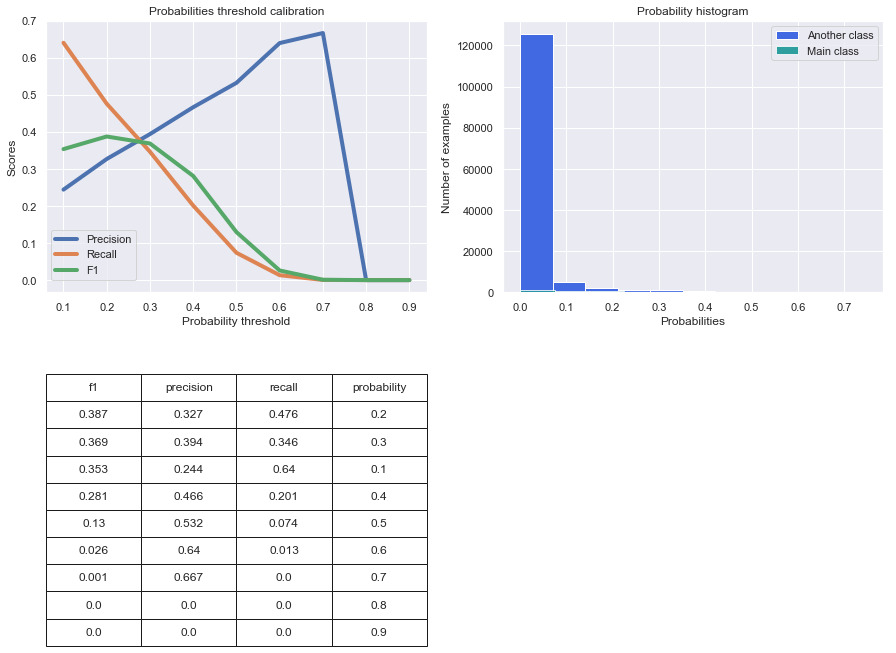

In [46]:
show_proba_calibration_plots(predict_test_probas, y_test)

### Подготовка данных для предсказания

In [47]:
X_best_train = train_new.drop(['user_id', 'is_churned'], axis=1)[best_feature]
y_best_train = train_new['is_churned']

scaler = StandardScaler()
X_ss = scaler.fit_transform(X_best_train)

X_full_train_balanced, y_full_train_balanced = ADASYN(random_state=21,
                                                      sampling_strategy=0.4).fit_sample(X_ss,
                                                                                        y_best_train)

In [48]:
X_test_final = scaler.transform(test_new.drop(['user_id'], axis=1)[best_feature])

In [49]:
model_final = clf_final.fit(X_full_train_balanced, y_full_train_balanced)
predict_results = model_final.predict(X_test_final)
predict_results_probas = model_final.predict_proba(X_test_final)[:, 1]

In [50]:
# calibration
predict_results_calbr = predict_results.copy()
predict_results_calbr[np.where(predict_results_probas > 0.3)] = 1

In [51]:
print(f'До калибровки: {Counter(predict_results)}')
print(f'После калибровки: {Counter(predict_results_calbr)}')

До калибровки: Counter({0: 43733, 1: 1031})
После калибровки: Counter({0: 42607, 1: 2157})


In [52]:
with open('models/model_xgb_final.pcl', 'wb') as f:
    pickle.dump(model_final, f)
    
with open('models/standard_scaler_final.pcl', 'wb') as f:
    pickle.dump(scaler, f)

In [53]:
pred_is_churned = pd.DataFrame({'user_id': test_new['user_id'], 'is_churned': predict_results_calbr},
                               columns=['user_id', 'is_churned'])
pred_is_churned.to_csv('Predictions.csv', sep=',', index=None, encoding='utf-8')

In [54]:
print(f'Notebook work: {time_format(time.time()-start_notebook)}')

Notebook work: 1:46:15.995145
